### Reinvestigating Flight Data

This file is where I will be looking at the flight data as preparation for the lawsuit against city council filed by someone in Garden City, Long Island. The data read into this file comes from the result of running 01_clean_helicopters.R, 02_clean_fr24.R, and the first half of 01_wrangle_flights.R. The end goal of this analysis is to discover if flight paths to JFK and La Guardia run over Garden City. 

In [1]:
# imports
import pandas as pd
import rpy2.robjects as ro
from rpy2.robjects import conversion, default_converter
from rpy2.robjects.vectors import ListVector
import pyarrow
import geopandas as gpd
from shapely.geometry import LineString
import matplotlib.pyplot as plt
import contextily as cx




/Users/CPorter/Desktop/CouncilConnect-Analysis/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Load in flight summary data
flight_summaries = pd.read_csv("../data/output/flight_summary.csv")

In [3]:
flight_summaries

,hex_id,transmission_id,flight_id,flight_start_timestamp,flight_start_event,flight_start_heliport_name,flight_start_bbox_edge,flight_start_state,flight_end_timestamp,flight_end_bbox_edge,flight_end_heliport_name,flight_duration_secs,starts_at,ends_at
0,0126886,1,1,2023-05-03T02:16:42Z,transmission_start,NaN,NaN,New York,2023-05-03T02:37:32Z,NaN,NaN,1250,unknown,unknown
1,0226970,3,2,2023-05-03T18:26:25Z,transmission_start,NaN,E,New York,2023-05-03T18:40:17Z,S,NaN,832,bbox,bbox
2,0226970,4,3,2023-05-03T20:23:44Z,transmission_start,NaN,S,New Jersey,2023-05-03T20:37:36Z,E,NaN,832,bbox,bbox
3,0226970,7,4,2023-05-05T17:00:44Z,transmission_start,NaN,N,New York,2023-05-05T17:35:23Z,E,NaN,2079,bbox,bbox
4,0226970,9,5,2023-05-07T17:36:34Z,transmission_start,NaN,S,New Jersey,2023-05-07T17:49:26Z,E,NaN,772,bbox,bbox
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9339,NaN,7014,9380,2023-05-17T15:05:34Z,transmission_start,NaN,S,New Jersey,2023-05-17T15:36:46Z,NaN,Teterboro Airport,1872,bbox,heliport
9340,NaN,7015,9381,2023-05-17T16:49:10Z,transmission_start,Teterboro Airport,NaN,New Jersey,2023-05-17T17:12:22Z,S,NaN,1392,heliport,bbox
9341,NaN,7016,9382,2023-05-18T18:39:40Z,transmission_start,NaN,E,New York,2023-05-18T18:58:05Z,S,NaN,1105,bbox,bbox
9342,NaN,7018,9383,2023-05-21T17:12:00Z,transmission_start,NaN,E,New York,2023-05-21T17:20:56Z,S,NaN,536,bbox,bbox


In [4]:
print(flight_summaries['flight_id'].max())
print(len(flight_summaries))

9384
9344


In [5]:
# Seeing if we can just read in all of the point data instead, and sort of manually replace what was done in 01_wrangle_flights.R

flight_points = pd.read_parquet("../data/output/flight_points/")

In [6]:
flight_points

,hex_id,callsign,squawk,obs_id,transmission_id,transmission_obs_id,flight_id,flight_obs_id,event_id,event,alt_ft,speed,heading,timestamp,bbox_edge,heliport_name,state,lon,lat
0,N104RT,N104RT,0000,8630,97,1,60,1,60,transmission_start,0.0,9,295,2023-05-01 12:52:38+00:00,None,Essex County Airport,New Jersey,-74.27933,40.87567
1,N104RT,N104RT,0000,8631,97,2,60,2,60,transmission_start,0.0,8,233,2023-05-01 12:52:44+00:00,None,Essex County Airport,New Jersey,-74.27957,40.87566
2,N104RT,N104RT,0000,8632,97,3,60,3,60,transmission_start,800.0,27,210,2023-05-01 12:52:52+00:00,None,Essex County Airport,New Jersey,-74.28000,40.87515
3,N104RT,N104RT,0000,8633,97,4,60,4,60,transmission_start,800.0,36,211,2023-05-01 12:52:57+00:00,None,Essex County Airport,New Jersey,-74.28064,40.87436
4,N104RT,N104RT,0000,8634,97,5,60,5,60,transmission_start,900.0,39,196,2023-05-01 12:53:03+00:00,None,Essex County Airport,New Jersey,-74.28112,40.87352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2336250,N9BQ,N9BQ,1200,2660837,6983,1379,9358,1379,9358,transmission_start,100.0,95,252,2023-05-31 22:30:28+00:00,None,Linden Airport,New Jersey,-74.23267,40.61998
2336251,N9BQ,N9BQ,1200,2660838,6983,1380,9358,1380,9358,transmission_start,0.0,92,250,2023-05-31 22:30:31+00:00,None,Linden Airport,New Jersey,-74.23370,40.61971
2336252,N9BQ,N9BQ,1200,2660839,6983,1381,9358,1381,9358,transmission_start,0.0,91,250,2023-05-31 22:30:34+00:00,None,Linden Airport,New Jersey,-74.23560,40.61925
2336253,N9BQ,N9BQ,1200,2660840,6983,1382,9358,1382,9358,transmission_start,0.0,88,251,2023-05-31 22:30:36+00:00,None,Linden Airport,New Jersey,-74.23731,40.61879


In [7]:
# Convert flight_points to geodataframe
flight_points = gpd.GeoDataFrame(
    flight_points,
    geometry=gpd.points_from_xy(flight_points["lon"], flight_points["lat"]),
    crs="EPSG:4326"  
)

In [8]:
flight_lines = (
    flight_points
    .groupby("flight_id", as_index=False)
    .agg({
        "geometry": lambda x: LineString(x.tolist())
    })
)

flight_lines = gpd.GeoDataFrame(flight_lines, geometry="geometry", crs=flight_points.crs)

In [9]:
print(len(flight_lines))
flight_lines

9173


,flight_id,geometry
0,1,"LINESTRING (-73.93372 40.54362, -73.94086 40.5..."
1,2,"LINESTRING (-73.53181 40.58931, -73.53636 40.5..."
2,3,"LINESTRING (-73.97032 40.36303, -73.97083 40.3..."
3,4,"LINESTRING (-73.89598 41.04441, -73.89529 41.0..."
4,5,"LINESTRING (-74.02882 40.36982, -74.02704 40.3..."
...,...,...
9168,9380,"LINESTRING (-73.97207 40.36922, -73.97226 40.3..."
9169,9381,"LINESTRING (-74.05029 40.85853, -74.04673 40.8..."
9170,9382,"LINESTRING (-73.52479 40.73273, -73.53494 40.7..."
9171,9383,"LINESTRING (-73.53215 40.70587, -73.53562 40.7..."


NOTE: The number of flight lines doesn't match up with the number of flight summaries!!! Need to figure out why!

In [10]:
# Merge flight_lines and flight_summaries
flights = pd.merge(flight_lines, flight_summaries, how='inner', left_on='flight_id', right_on='flight_id')
flights = gpd.GeoDataFrame(flights, geometry='geometry', crs='EPSG:4326')
flights

,flight_id,geometry,hex_id,transmission_id,flight_start_timestamp,flight_start_event,flight_start_heliport_name,flight_start_bbox_edge,flight_start_state,flight_end_timestamp,flight_end_bbox_edge,flight_end_heliport_name,flight_duration_secs,starts_at,ends_at
0,1,"LINESTRING (-73.93372 40.54362, -73.94086 40.5...",0126886,1,2023-05-03T02:16:42Z,transmission_start,NaN,NaN,New York,2023-05-03T02:37:32Z,NaN,NaN,1250,unknown,unknown
1,2,"LINESTRING (-73.53181 40.58931, -73.53636 40.5...",0226970,3,2023-05-03T18:26:25Z,transmission_start,NaN,E,New York,2023-05-03T18:40:17Z,S,NaN,832,bbox,bbox
2,3,"LINESTRING (-73.97032 40.36303, -73.97083 40.3...",0226970,4,2023-05-03T20:23:44Z,transmission_start,NaN,S,New Jersey,2023-05-03T20:37:36Z,E,NaN,832,bbox,bbox
3,4,"LINESTRING (-73.89598 41.04441, -73.89529 41.0...",0226970,7,2023-05-05T17:00:44Z,transmission_start,NaN,N,New York,2023-05-05T17:35:23Z,E,NaN,2079,bbox,bbox
4,5,"LINESTRING (-74.02882 40.36982, -74.02704 40.3...",0226970,9,2023-05-07T17:36:34Z,transmission_start,NaN,S,New Jersey,2023-05-07T17:49:26Z,E,NaN,772,bbox,bbox
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9168,9380,"LINESTRING (-73.97207 40.36922, -73.97226 40.3...",NaN,7014,2023-05-17T15:05:34Z,transmission_start,NaN,S,New Jersey,2023-05-17T15:36:46Z,NaN,Teterboro Airport,1872,bbox,heliport
9169,9381,"LINESTRING (-74.05029 40.85853, -74.04673 40.8...",NaN,7015,2023-05-17T16:49:10Z,transmission_start,Teterboro Airport,NaN,New Jersey,2023-05-17T17:12:22Z,S,NaN,1392,heliport,bbox
9170,9382,"LINESTRING (-73.52479 40.73273, -73.53494 40.7...",NaN,7016,2023-05-18T18:39:40Z,transmission_start,NaN,E,New York,2023-05-18T18:58:05Z,S,NaN,1105,bbox,bbox
9171,9383,"LINESTRING (-73.53215 40.70587, -73.53562 40.7...",NaN,7018,2023-05-21T17:12:00Z,transmission_start,NaN,E,New York,2023-05-21T17:20:56Z,S,NaN,536,bbox,bbox


In [ ]:
# load in Garden City map
# Source: https://data.gis.ny.gov/datasets/sharegisny::villages/explore?location=40.687743%2C-73.755036%2C12.36
garden_city = gpd.read_file('../data/input/Shapefiles/garden_city.shp')
garden_city_for_map = garden_city.to_crs(epsg=3857)


In [19]:
# Add column with boolean for if flight path intersects with Garden City
garden_city = garden_city.to_crs(epsg=4326)
print(garden_city.crs)
print(flights.crs)
garden_city_poly = garden_city.geometry.iloc[0]

flights['thru_garden_city'] = flights.intersects(garden_city_poly)
print(len(flights))
print(f"TOTAL INTERSECT WITH GARDEN CITY: {flights['thru_garden_city'].sum()}")

EPSG:4326
EPSG:4326
9173
TOTAL INTERSECT WITH GARDEN CITY: 152


In [24]:
# Get rid of NYPD flights
flights = flights[~flights['hex_id'].str.contains("PD", na=False)]
print(len(flights))
print(f"TOTAL INTERSECT WITH GARDEN CITY: {flights['thru_garden_city'].sum()}")

8838
TOTAL INTERSECT WITH GARDEN CITY: 151


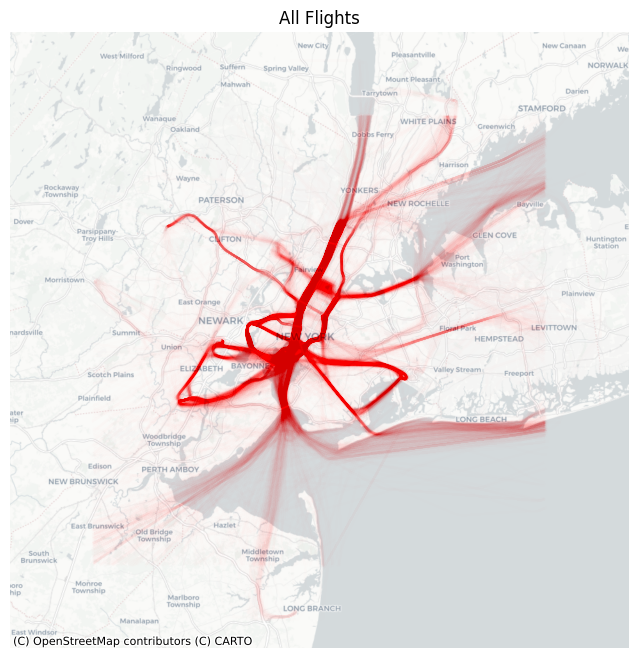

In [42]:
flight_lines_for_map = flights.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(8,8))

flight_lines_for_map.plot(
    ax=ax,
    linewidth=2,
    color="red", 
    alpha=0.005
)

cx.add_basemap(
    ax,
    source=cx.providers.CartoDB.Positron  # clean NYC basemap
)

ax.set_axis_off()
ax.set_title("All Flights")
plt.show()

FLIGHTS ENTERING OR EXITING EAST OF BOUNDING BOX: 1223
FLIGHTS ENTERING OR EXITING EAST OF BOUNDING BOX OVER GARDEN CITY: 139
PERCENT OVER GARDEN CITY: 11.4


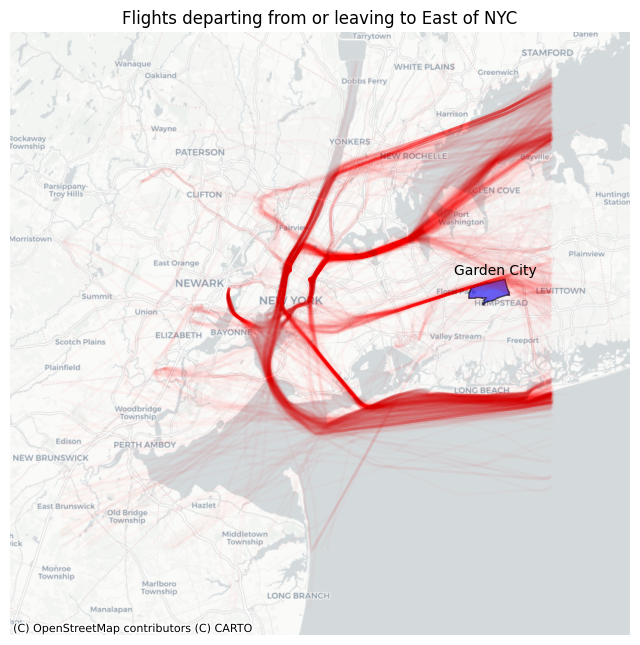

In [41]:
# Map just flights that enter or exit the East side of bounding box
flights_east = flights[(flights['flight_start_bbox_edge'] == 'E') | (flights['flight_end_bbox_edge'] == 'E')]
print(f"FLIGHTS ENTERING OR EXITING EAST OF BOUNDING BOX: {len(flights_east)}")
print(f"FLIGHTS ENTERING OR EXITING EAST OF BOUNDING BOX OVER GARDEN CITY: {flights_east['thru_garden_city'].sum()}")
print(f"PERCENT OVER GARDEN CITY: {round(flights_east['thru_garden_city'].sum() / len(flights_east) * 100,1)}")

flight_lines_for_map = flights_east.to_crs(epsg=3857)
fig, ax = plt.subplots(figsize=(8,8))

# Plot lines
flight_lines_for_map.plot(
    ax=ax,
    linewidth=2,
    color="red", 
    alpha=0.02
)

# Plot Garden City
garden_city_for_map.plot(ax=ax, color='blue', alpha=0.6, edgecolor='black')

# Add label for Garden City
row = garden_city_for_map.iloc[0]
point = row.geometry.representative_point()
ax.annotate("Garden City", xy=(point.x, point.y), xytext=(5,20), textcoords="offset points", ha="center", va="top")

cx.add_basemap(
    ax,
    source=cx.providers.CartoDB.Positron  # clean NYC basemap
)

ax.set_axis_off()
ax.set_title("Flights departing from or leaving to East of NYC")
plt.show()

FLIGHTS BETWEEN E. MANHATTAN AND EAST OF BOUNDING BOX: 312
FLIGHTS BETWEEN E. MANHATTAN AND EAST OF BOUNDING BOX OVER GARDEN CITY: 26
PERCENT OVER GARDEN CITY: 8.3


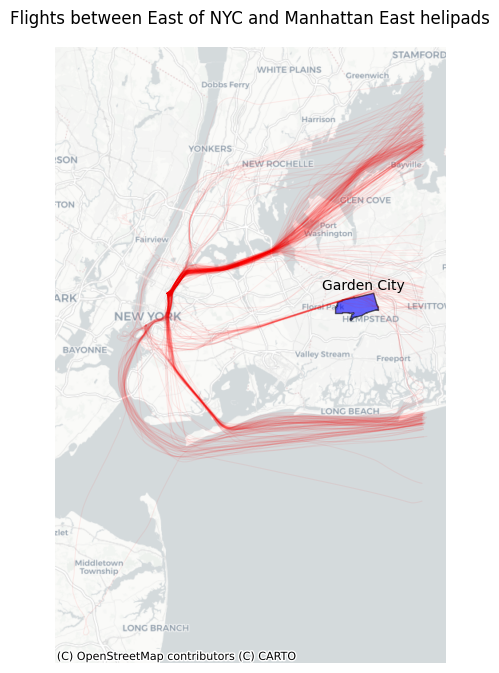

In [45]:
# Map Flights east of NYC that end at now-off-limits heliports
# print(flights_east['flight_end_heliport_name'].value_counts())

manhattan_heliports = ['East 34th Street Heliport', 'Downtown Manhattan Heliport']

flights_east_to_manhattan = flights_east[(flights_east['flight_end_heliport_name'].isin(manhattan_heliports)) | flights_east['flight_start_heliport_name'].isin(manhattan_heliports)]
flights_east_to_manhattan_map = flights_east_to_manhattan.to_crs(epsg=3857)

print(f"FLIGHTS BETWEEN E. MANHATTAN AND EAST OF BOUNDING BOX: {len(flights_east_to_manhattan)}")
print(f"FLIGHTS BETWEEN E. MANHATTAN AND EAST OF BOUNDING BOX OVER GARDEN CITY: {flights_east_to_manhattan['thru_garden_city'].sum()}")
print(f"PERCENT OVER GARDEN CITY: {round(flights_east_to_manhattan['thru_garden_city'].sum() / len(flights_east_to_manhattan) * 100,1)}")

fig, ax = plt.subplots(figsize=(8,8))

# Plot lines
flights_east_to_manhattan_map.plot(
    ax=ax,
    linewidth=0.8,
    color="red", 
    alpha=0.06
)

# Plot Garden City
garden_city_for_map.plot(ax=ax, color='blue', alpha=0.6, edgecolor='black')

# Add label for Garden City
row = garden_city_for_map.iloc[0]
point = row.geometry.representative_point()
ax.annotate("Garden City", xy=(point.x, point.y), xytext=(5,20), textcoords="offset points", ha="center", va="top")

cx.add_basemap(
    ax,
    source=cx.providers.CartoDB.Positron  # clean NYC basemap
)

ax.set_axis_off()
ax.set_title("Flights between East of NYC and Manhattan East helipads")
plt.show()


FLIGHTS BETWEEN E. MANHATTAN AND EAST OF BOUNDING BOX: 411
FLIGHTS BETWEEN E. MANHATTAN AND EAST OF BOUNDING BOX OVER GARDEN CITY: 39
PERCENT OVER GARDEN CITY: 9.5


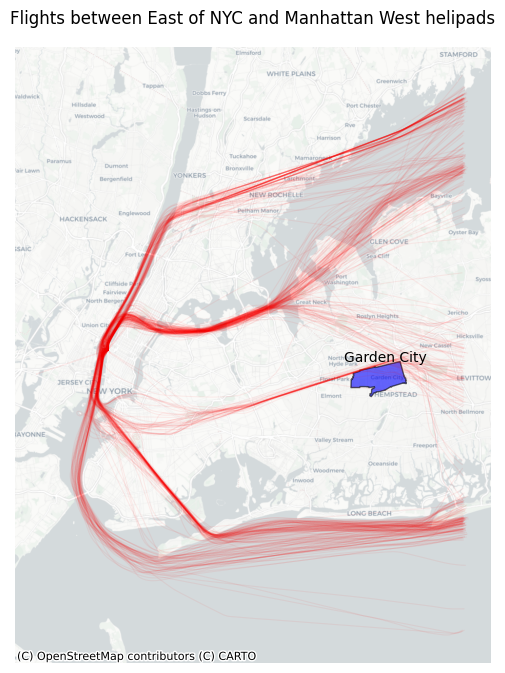

In [46]:
manhattan_w_heliports = ['West 30th Street Heliport']

flights_east_to_manhattan_west = flights_east[(flights_east['flight_end_heliport_name'].isin(manhattan_w_heliports)) | flights_east['flight_start_heliport_name'].isin(manhattan_w_heliports)]
flights_east_to_manhattan_west_map = flights_east_to_manhattan_west.to_crs(epsg=3857)

print(f"FLIGHTS BETWEEN E. MANHATTAN AND EAST OF BOUNDING BOX: {len(flights_east_to_manhattan_west)}")
print(f"FLIGHTS BETWEEN E. MANHATTAN AND EAST OF BOUNDING BOX OVER GARDEN CITY: {flights_east_to_manhattan_west['thru_garden_city'].sum()}")
print(f"PERCENT OVER GARDEN CITY: {round(flights_east_to_manhattan_west['thru_garden_city'].sum() / len(flights_east_to_manhattan_west) * 100,1)}")

fig, ax = plt.subplots(figsize=(8,8))

# Plot lines
flights_east_to_manhattan_west_map.plot(
    ax=ax,
    linewidth=0.8,
    color="red", 
    alpha=0.06
)

# Plot Garden City
garden_city_for_map.plot(ax=ax, color='blue', alpha=0.6, edgecolor='black')

# Add label for Garden City
row = garden_city_for_map.iloc[0]
point = row.geometry.representative_point()
ax.annotate("Garden City", xy=(point.x, point.y), xytext=(5,20), textcoords="offset points", ha="center", va="top")

cx.add_basemap(
    ax,
    source=cx.providers.CartoDB.Positron  # clean NYC basemap
)

ax.set_axis_off()
ax.set_title("Flights between East of NYC and Manhattan West helipads")
plt.show()


FLIGHTS STARTING EAST TO JFK OR LGA: 49
FLIGHTS STARTING EAST TO JFK OR LGA OVER GARDEN CITY: 26
PERCENT OVER GARDEN CITY: 53.1


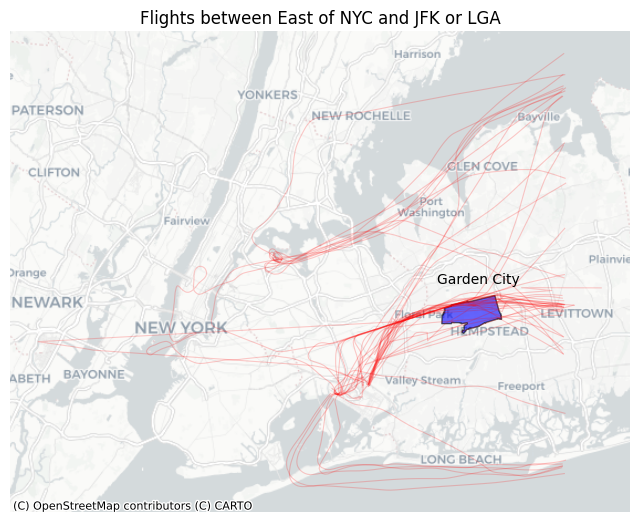

In [ ]:
# map flights from east to JFK and LGA
airports = ['JFK Airport', 'LaGuardia Airport']
flights_east_to_airport = flights_east[(flights_east['flight_end_heliport_name'].isin(airports)) | (flights_east['flight_start_heliport_name'].isin(airports))]
print(f"FLIGHTS BETWEEN EAST OF BOUNDING BOX AND JFK OR LGA: {len(flights_east_to_airport)}")
print(f"FLIGHTS BETWEEN EAST OF BOUNDING BOX AND JFK OR LGA OVER GARDEN CITY: {flights_east_to_airport['thru_garden_city'].sum()}")
print(f"PERCENT OVER GARDEN CITY: {round(flights_east_to_airport['thru_garden_city'].sum() / len(flights_east_to_airport) * 100, 1)}")

flights_east_to_airport_map = flights_east_to_airport.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(8,8))

# Plot lines
flights_east_to_airport_map.plot(
    ax=ax,
    linewidth=0.8,
    color="red", 
    alpha=0.2
)

# Plot Garden City
garden_city_for_map.plot(ax=ax, color='blue', alpha=0.6, edgecolor='black')

# Add label for Garden City
row = garden_city_for_map.iloc[0]
point = row.geometry.representative_point()
ax.annotate("Garden City", xy=(point.x, point.y), xytext=(5,30), textcoords="offset points", ha="center", va="top")

cx.add_basemap(
    ax,
    source=cx.providers.CartoDB.Positron  # clean NYC basemap
)

ax.set_axis_off()
ax.set_title("Flights between East of NYC and JFK or LGA")
plt.show()